### Deeper Look Inside RetinaNet
- What does its anchor boxes look like? 
- What is each helper function doing?
- How to Recover BBox from its output?
- Why rescaling are applied in activ_to_bbox as regularization?

### Notes
- bbox regressor activation indicates offset [off_x, off_y, off_w, off_h]
- **loss function expects target bboxs to be in the form of [center x, center y, w, h]**
- there are helper functions to convert bbox from [off_x, off_y, off_w, off_h] to [center_x, center_y, w, h]

### Idea
1. visualized Merge Upsampling Layer
2. in training loop, plot the classification activations distribution (whether the improvement comes from less confidence prediction, or more confidence prediction)

### Reference
- [fastai nbs dl2 on ReinaNet](https://github.com/fastai/course-v3/blob/master/nbs/dl2/pascal.ipynb)

In [1]:
import os
import sys
path = os.path.join(os.getcwd(), '..')
sys.path.append(path)

from pdb import set_trace
import warnings 
warnings.filterwarnings("ignore")

from fastai2.vision.all import *

from src.data.dblock import build_dblock
from src.data.dls import build_dataloaders
from src.model.model import get_retinanet, split_param_groups
from src.metrics.loss import get_retinanet_loss
from src.metrics.mAP import mAP

%load_ext autoreload
%autoreload 2

In [2]:
data_path = '/userhome/34/h3509807/wheat-data'

In [3]:
dls = build_dataloaders(
    data_path, bs = 8, 
    resize_sz = 256, norm = False, 
    rand_seed = 144, test_mode = True
    )

#### 1a. Encore Boxes: PyTorch Playground

In [17]:
grids = torch.arange(0, 16).long().view(4, 4)
grids

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]])

In [24]:
W = 4
torch.linspace(-1+1/W, 1-1/W, W)

tensor([-0.7500, -0.2500,  0.2500,  0.7500])

In [42]:
grid.expand_as??

In [38]:
grid = FloatTensor(4, 4, 2)
v1 = torch.arange(1, 5)
v2 = torch.arange(1, 5)
#torch.ger(v1, v2).expand_as(grid[:, :, 0])
torch.ger(v1, v2)

tensor([[ 1,  2,  3,  4],
        [ 2,  4,  6,  8],
        [ 3,  6,  9, 12],
        [ 4,  8, 12, 16]])

#### 1b. Visualize Simple (Square) Encore Boxes

In [46]:
def create_grid(size):
    """ 
    tensor of grid center expressed in 
    grid.shape = (# GRID, 2) 
    -1: top/ left, +1: bottom/ right
    """
    H, W = size if isinstance(size, tuple) else (size,size)
    grid = FloatTensor(H, W, 2)
    linear_points = torch.linspace(-1+1/W, 1-1/W, W) if W > 1 else tensor([0.])
    grid[:, :, 1] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, 0])
    linear_points = torch.linspace(-1+1/H, 1-1/H, H) if H > 1 else tensor([0.])
    grid[:, :, 0] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, 1])
    return grid.view(-1,2)

In [50]:
create_grid((2, 3))

tensor([[-0.5000, -0.6667],
        [-0.5000,  0.0000],
        [-0.5000,  0.6667],
        [ 0.5000, -0.6667],
        [ 0.5000,  0.0000],
        [ 0.5000,  0.6667]])

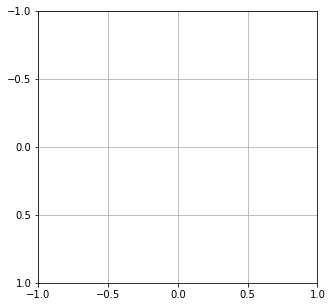

In [82]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
ax.set_xticks(np.linspace(-1, 1, 4+1))
ax.set_yticks(np.linspace(-1, 1, 4+1))
ax.set_xlim(-1, 1)
ax.set_ylim(1, -1)
ax.grid()
#ax.set_yticklabels([])
#ax.set_xticklabels([])

In [93]:
def show_anchors(ancs, size):
    _,ax = plt.subplots(1,1, figsize=(8, 8))
    ax.set_xticks(np.linspace(-1, 1, size[1]+1))
    ax.set_yticks(np.linspace(-1, 1, size[0]+1))
    ax.grid()
    ax.scatter(ancs[:,1], ancs[:,0]) #y is first
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim(-1, 1)
    ax.set_ylim(1, -1) #-1 is top, 1 is bottom
    for i, (x, y) in enumerate(zip(ancs[:, 1], ancs[:, 0])): 
        ax.annotate(f'{i}: ({x},{y})', xy = (x-0.15, y-0.1))

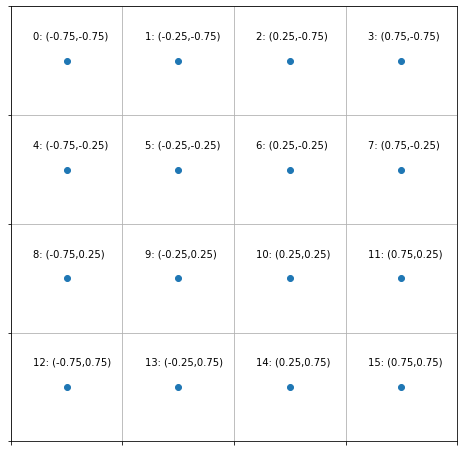

In [94]:
size = (4, 4)
show_anchors(create_grid(size), size)

#### 1c. Visualize Encore Boxes of Varying Ratios, Scales

In [110]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from matplotlib import patches, patheffects
from cycler import cycler

In [95]:
def create_anchors(sizes, ratios, scales, flatten=True):
    "Create anchor of `sizes`, `ratios` and `scales`."
    aspects = [[[s*math.sqrt(r), s*math.sqrt(1/r)] for s in scales] for r in ratios]
    aspects = torch.tensor(aspects).view(-1,2)
    anchors = []
    for h,w in sizes:
        # 4 here to have the anchors overlap.
        sized_aspects = 4 * (aspects * torch.tensor([2/h,2/w])).unsqueeze(0)
        base_grid = create_grid((h,w)).unsqueeze(1)
        n,a = base_grid.size(0),aspects.size(0)
        ancs = torch.cat([base_grid.expand(n,a,2), sized_aspects.expand(n,a,2)], 2)
        anchors.append(ancs.view(h,w,a,4))
    return torch.cat([anc.view(-1,4) for anc in anchors],0) if flatten else anchors

In [96]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)] 
#Paper used [1,2**(1/3), 2**(2/3)] but a bigger size (600) too, so the largest feature map gave anchors that cover less of the image.
sizes = [(2**i,2**i) for i in range(5)]
sizes.reverse() #Predictions come in the order of the smallest feature map to the biggest
anchors = create_anchors(sizes, ratios, scales)

In [106]:
# there are 5 features map of various sizes 
# for each grid of a features map, it has 9 anchor boxes of different ratios and scales
anchors.size(), sum([(2**i) * (2**i) * 9 for i in range(5)])

(torch.Size([3069, 4]), 3069)

In [ ]:
def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_color = 12
cmap = get_cmap(num_color)
color_list = [cmap(float(x)) for x in range(num_color)]

In [102]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def show_boxes(boxes):
    "Show the `boxes` (size by 4)"
    _, ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1)
    for i, bbox in enumerate(boxes):
        bb = bbox.numpy()
        rect = [bb[1]-bb[3]/2, bb[0]-bb[2]/2, bb[3], bb[2]]
        draw_rect(ax, rect, color=color_list[i % num_color])
        draw_text(ax, [bb[1]-bb[3]/2,bb[0]-bb[2]/2], str(i), color=color_list[i % num_color])

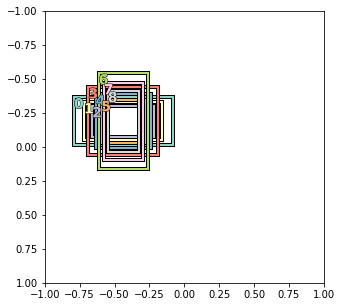

In [111]:
show_boxes(anchors[900:909])

#### 2. Recovering Predicted BBoxes from Model Output
regression subnet output 4 floating points for a predicted bboxes: [p_y, p_x, p_h, p_w]. predicted bboxes can be recovered by:  
- center = [p_y * anc_h + anc_y, p_x * anc_w + anc_x]  
- height = anc_h * exp(p_h)  
- weight = anc_w * exp(p_w)  

if [p_y, p_x, p_h, p_w], predicted bbox is exactly the same as the outstanding anchor box.

In [137]:
def activ_to_bbox(acts, anchors, flatten = True):
    """
    from offset params to [center x, center y, width, height] 
    """
    if flatten:
        # why there is a scaling on activation??
        acts.mul_(acts.new_tensor([[0.1, 0.1, 0.2, 0.2]]))
        centers = anchors[..., 2:] * acts[..., :2] + anchors[..., :2]
        sizes = anchors[..., 2:] * torch.exp(acts[..., :2])
        return torch.cat([centers, sizes], -1)
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

In [144]:
size=(3, 4)
anchors = create_grid(size)
anchors = torch.cat([anchors, torch.tensor([2/size[0],2/size[1]]).expand_as(anchors)], 1)
anchors

tensor([[-0.6667, -0.7500,  0.6667,  0.5000],
        [-0.6667, -0.2500,  0.6667,  0.5000],
        [-0.6667,  0.2500,  0.6667,  0.5000],
        [-0.6667,  0.7500,  0.6667,  0.5000],
        [ 0.0000, -0.7500,  0.6667,  0.5000],
        [ 0.0000, -0.2500,  0.6667,  0.5000],
        [ 0.0000,  0.2500,  0.6667,  0.5000],
        [ 0.0000,  0.7500,  0.6667,  0.5000],
        [ 0.6667, -0.7500,  0.6667,  0.5000],
        [ 0.6667, -0.2500,  0.6667,  0.5000],
        [ 0.6667,  0.2500,  0.6667,  0.5000],
        [ 0.6667,  0.7500,  0.6667,  0.5000]])

In [145]:
activations = torch.randn(size[0] * size[1], 4) * 0.1
bboxes = activ_to_bbox(activations, anchors)
bboxes

tensor([[-0.6608, -0.7466,  0.6725,  0.5034],
        [-0.6531, -0.2489,  0.6803,  0.5011],
        [-0.6604,  0.2502,  0.6730,  0.5002],
        [-0.6770,  0.7451,  0.6564,  0.4951],
        [-0.0025, -0.7558,  0.6642,  0.4943],
        [ 0.0027, -0.2487,  0.6694,  0.5013],
        [ 0.0021,  0.2505,  0.6688,  0.5005],
        [ 0.0019,  0.7447,  0.6686,  0.4947],
        [ 0.6634, -0.7478,  0.6634,  0.5022],
        [ 0.6692, -0.2537,  0.6692,  0.4963],
        [ 0.6638,  0.2466,  0.6638,  0.4966],
        [ 0.6688,  0.7422,  0.6688,  0.4923]])

In [146]:
def cthw2tlbr(boxes):
    "Convert center/size format `boxes` to top/left bottom/right corners."
    top_left = boxes[:,:2] - boxes[:,2:]/2
    bot_right = boxes[:,:2] + boxes[:,2:]/2
    return torch.cat([top_left, bot_right], 1)

In [149]:
tlbr_bboxes = cthw2tlbr(bboxes)
tlbr_bboxes

tensor([[-9.9710e-01, -9.9831e-01, -3.2459e-01, -4.9489e-01],
        [-9.9330e-01, -4.9944e-01, -3.1295e-01,  1.6895e-03],
        [-9.9687e-01,  8.2582e-05, -3.2390e-01,  5.0025e-01],
        [-1.0052e+00,  4.9753e-01, -3.4878e-01,  9.9263e-01],
        [-3.3456e-01, -1.0029e+00,  3.2965e-01, -5.0864e-01],
        [-3.3197e-01, -4.9935e-01,  3.3744e-01,  1.9658e-03],
        [-3.3228e-01,  2.3323e-04,  3.3649e-01,  5.0070e-01],
        [-3.3239e-01,  4.9732e-01,  3.3616e-01,  9.9201e-01],
        [ 3.3172e-01, -9.9891e-01,  9.9516e-01, -4.9671e-01],
        [ 3.3461e-01, -5.0188e-01,  1.0038e+00, -5.6102e-03],
        [ 3.3192e-01, -1.7260e-03,  9.9576e-01,  4.9485e-01],
        [ 3.3439e-01,  4.9607e-01,  1.0032e+00,  9.8833e-01]])

#### 3. More about RetinaNet Modules

In [117]:
model = get_retinanet()

#### 3a. Classification Subnet
- classification subnet of fastai's RetinaNet doesn't include sigmoid activation function at the end.
- final number of filters is 9 because we have one class (wheat) and 9 different anchor boxes per grid (i.e. 1*9 = 9). Note that unlike YOLO and SSD, background doesn't include as a class so we only have 1 class in this case.

In [115]:
model.classifier

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

##### 3b. Box Regression Subnet
- Final number of filters are 36 because we have 4 floating outputs for a bounding box, and 9 anchor boxes per grid (i.e. 4*9 = 36).

In [116]:
model.box_regressor

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

#### 3xxx. Try to Visualize LateralUpsampleMerge
visualize how two features 1d map adding together

#### 3c. Overall Model Hierarchy

In [132]:
for idx, (name, m) in enumerate(model.named_children()):
    l = len(m) if isinstance(m, nn.Sequential) else 0
    print(f'{idx}: {name} ({l})')

0: encoder (8)
1: c5top5 (0)
2: c5top6 (0)
3: p6top7 (2)
4: merges (0)
5: smoothers (0)
6: classifier (5)
7: box_regressor (5)


#### 4. Process RetinaNet Outputs